# Data Preprocessing

In [2]:
# some magic so that the notebook will reload external python modules;
# see https://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [1]:
import os
import subprocess
import sys
import numpy as np
import matplotlib.pyplot as plt

import cv2
import torch

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## Getting Face Tracks

In [4]:
from data_processing.face_tracks import get_single_face_tracks
from data_processing.video_utils import clip_video_ffmpeg

In [ ]:
video_path = './datasets/Lip2Wav/jazzy/face_tracks/jazzy/track-0.mp4'
cap = cv2.VideoCapture(video_path)

ret, frame = cap.read()
plt.imshow(frame)

### Using MediaPipe

In [2]:
import mediapipe as mp

In [4]:
mp_face_detection = mp.solutions.face_detection
full_range_detector = mp_face_detection.FaceDetection(min_detection_confidence=0.5, model_selection=1)

print(mp_face_detection)
print(full_range_detector)

<module 'mediapipe.python.solutions.face_detection' from '/home/vanshg/anaconda3/envs/coursework/lib/python3.10/site-packages/mediapipe/python/solutions/face_detection.py'>


I0000 00:00:1721202682.647204   17112 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1721202682.696608   18820 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.183.01), renderer: NVIDIA GeForce RTX 3050 6GB Laptop GPU/PCIe/SSE2


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1721202682.745288   18814 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


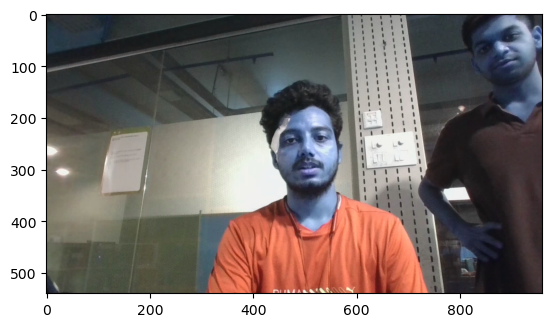

In [6]:
video_path = "./data/1.webm"

cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()

plt.imshow(frame)

In [9]:
detector = full_range_detector
print(frame.shape)
results = full_range_detector.process(frame)

(540, 960, 3)


/home/vanshg/anaconda3/envs/coursework/lib/python3.10/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


In [11]:
print(results.detections)

[label_id: 0
score: 0.9043416380882263
location_data {
  format: RELATIVE_BOUNDING_BOX
  relative_bounding_box {
    xmin: 0.4535520672798157
    ymin: 0.36569225788116455
    width: 0.14436769485473633
    height: 0.256639301776886
  }
  relative_keypoints {
    x: 0.4975486993789673
    y: 0.450253963470459
  }
  relative_keypoints {
    x: 0.554945170879364
    y: 0.4402013421058655
  }
  relative_keypoints {
    x: 0.5281853079795837
    y: 0.5001134872436523
  }
  relative_keypoints {
    x: 0.5299574136734009
    y: 0.5496947765350342
  }
  relative_keypoints {
    x: 0.46577587723731995
    y: 0.488985538482666
  }
  relative_keypoints {
    x: 0.5903559923171997
    y: 0.4748023748397827
  }
}
]


### Using RetinaFace

In [12]:
from ibug.face_alignment import FANPredictor
from ibug.face_detection import RetinaFacePredictor

In [15]:
model_name = "resnet50"
face_detector = RetinaFacePredictor(device=device, threshold=0.8, model=RetinaFacePredictor.get_model(model_name))

print(face_detector)

In [38]:
fps = int(cap.get(cv2.CAP_PROP_FPS))
print(fps)

15


frames.shape = (768, 360, 640, 3)


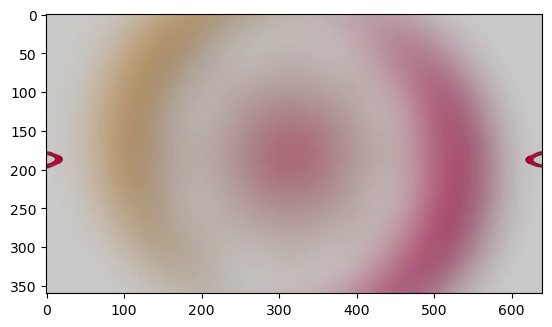

In [5]:
video_path = "./data/cut-0.mp4"

cap = cv2.VideoCapture(video_path)

frames = []
while cap.isOpened():
    ret, frame = cap.read()

    if not ret:
        break

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frames.append(frame_rgb)

frames = np.array(frames)
print(f"{frames.shape = }")

plt.imshow(frames[0])
plt.show()

In [51]:
# single_tracks = ["start_frame", "end_frame"]
tracks = []

for idx, frame in enumerate(frames):
    detected_faces = face_detector(frame, rgb=True)

    if len(detected_faces):
        detected_face = detected_faces[0]
        (x1, y1, x2, y2) = detected_face[:4]
        w, h = (x2 - x1), (y2 - y1)
        bbox = (x1, y1, w, h)

        if len(tracks):
            last_track = tracks[-1]
            last_track_frame = last_track['end_frame']
            if idx == last_track_frame + 1:
                last_track['end_frame'] = idx
                last_track['frames'].append(frame)
                last_track['bboxes'].append(bbox)
            else:
                print(f"New track started at frame idx: {idx}")
                new_track = {
                    "start_frame": idx,
                    "end_frame": idx,
                    "frames": [frame],
                    "bboxes": [bbox]
                }
                tracks.append(new_track)
        else:
            print(f"New track started at frame idx: {idx}")
            new_track = {
                "start_frame": idx,
                "end_frame": idx,
                "frames": [frame],
                "bboxes": [bbox]
            }
            tracks.append(new_track)


print(f"Total number of tracks = {len(tracks)}")

New track started at frame idx: 315
Total number of tracks = 1


In [8]:
tracks = get_single_face_tracks(frames, device)
print(f"Number of detected tracks = {len(tracks)}")

Processing Frames: 100%|██████████| 768/768 [00:18<00:00, 41.78it/s]

Number of detected tracks = 1


In [12]:
print(video_path)

./data/cut-0.mp4


In [19]:
track = tracks[0]
start_frame = track['start_frame']
end_frame = track['end_frame']
print(start_frame, end_frame)

fps = 15
start_time = int(start_frame/fps)
end_time = int(end_frame/fps) + 1

src_video_dir = os.path.dirname(video_path)

output_path = os.path.join(src_video_dir, "clip-1.mp4")

clip_video_ffmpeg(video_path, (start_time, end_time), output_path)

315 767


ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/tmp/build/80754af9/ffmpeg_1587154242452/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho --cc=/tmp/build/80754af9/ffmpeg_1587154242452/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100


128


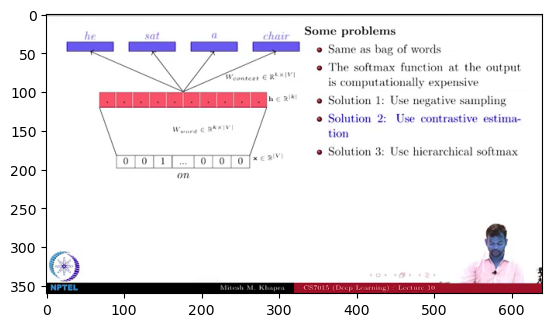

: 

In [22]:
new_vid_path = './data/clip-1.mp4'

new_frames = []
vid = cv2.VideoCapture(new_vid_path)

while vid.isOpened:
    ret, frame = vid.read()
    if not ret:
        break
    new_frames.append(frame)

print(len(new_frames))
plt.imshow(new_frames[0])